## ICASSP 2019 SED EXAMPLE

### Parameters, Imports and Data Collection

In [4]:
n_mels = 64
frame_width = 0.04
hop_width = 0.02
epochs = 100
clip_length = 10 #s
sequence_length = int(clip_length/hop_width) # 10s/0.02s=500 frames
fs = 44100 #Hz
dropout = 0.3
conv_filters = 128
gru_units = 32

In [24]:
import dcase_util
from dcase_util.containers import AudioContainer
import os, numpy
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
import sed_eval
from scipy import signal
%matplotlib inline

# Handy tool to print data in HTML form
log = dcase_util.ui.FancyHTMLPrinter()

# Paths to store data
data_storage_path = 'data'
dataset_storage_path = os.path.join(data_storage_path, 'datasets')
feature_storage_path = os.path.join(data_storage_path, 'features')
dcase_util.utils.Path().create(
    [data_storage_path, dataset_storage_path, feature_storage_path]
)

# # Filename for acoustic model
model_filename = os.path.join(data_storage_path, 'model_sed.h5')  

def get_feature_filename(audio_filename, feature_storage_path):
    """Get feature filename from audio filename. """
    
    return dcase_util.utils.Path(path=audio_filename).modify(
        path_base=feature_storage_path, 
        filename_extension='.npy'
    )
    
def get_feature_matrix(audio_filename, feature_storage_path=os.path.join('data', 'features')):  
    """Extract acoustic features (log mel-energies) for given audio file and store them."""
    
    feature_filename = get_feature_filename(audio_filename, feature_storage_path)
    if os.path.exists(feature_filename):
        return numpy.load(feature_filename)
    else:
        audio = dcase_util.containers.AudioContainer().load(filename=audio_filename,mono=True)
        mel_extractor = dcase_util.features.MelExtractor(n_mels=n_mels, win_length_seconds=frame_width, hop_length_seconds=hop_width, fs=audio.fs)
        mel_data = mel_extractor.extract(y=audio)
        numpy.save(feature_filename, mel_data)
        return mel_data
    
# Setup Keras to use tensorflow as backend
dcase_util.keras.setup_keras(backend='tensorflow')
import keras
from keras.layers import *
from keras.models import Model

In [6]:
db = dcase_util.datasets.TUTSoundEvents_2016_DevelopmentSet(
    data_path=dataset_storage_path
).initialize()

In [7]:
event_labels = db.event_labels()
data = db.meta.stats()
log.table(
    cell_data=[
        data['events']['event_label_list'],
        data['events']['count'],
        data['events']['length'],
        data['events']['avg_length'],
    ],
    column_headers=['Event label', 'Event count', 'Total length', 'Average event length'],
    column_types=['str20', 'int', 'float2', 'float2'],
    scaling=100
)

Event label,Event count,Total length,Average event length
(object) banging,15,11.36,0.76
(object) rustling,41,131.20,3.20
(object) snapping,42,18.76,0.45
bird singing,162,1081.62,6.68
car passing by,74,549.38,7.42
children shouting,23,46.17,2.01
cupboard,27,17.59,0.65
cutlery,56,41.50,0.74
dishes,94,116.97,1.24
drawer,23,18.36,0.80


## Meta data 

Meta data can be represented as **event list** and **event roll**

1) **Event list** &ndash; list of sound events with onset, offset, and label

In [8]:
event_list = db.meta.filter(filename=db.meta.unique_files[0])

In [9]:
event_list_ = dcase_util.containers.ListDictContainer(event_list[0:5])
onsets = event_list_.get_field('onset')
onsets.append('...')
offsets = event_list_.get_field('offset')
offsets.append('...')
labels = event_list_.get_field('event_label')
labels.append('...')
log.table(
    cell_data=[onsets, offsets, labels],
    column_headers=['Event onset', 'Event offset', 'Event label'],
    column_types=['float2', 'float2', 'str25'],
    scaling=110
)

Event onset,Event offset,Event label
5.94,6.28,(object) snapping
10.16,10.69,object impact
12.13,12.49,object impact
14.96,15.36,object impact
17.84,18.26,(object) snapping
,,...


2) **Event roll** &ndash; binary matrix where event presence is indicated with predefined time resolution, similar to *piano roll* in MIR

In [10]:
mel_extractor = dcase_util.features.MelExtractor(
    n_mels=n_mels, 
    win_length_seconds=frame_width,  # 40 ms 
    hop_length_seconds=hop_width,  # 20 ms
    fs=fs
)

# Event roll syncronized with feature extraction
event_roll = event_list.to_event_roll(
    time_resolution=mel_extractor.hop_length_seconds, 
    label_list=db.event_labels()
)


event_roll shape (classes, time) (17, 8995)


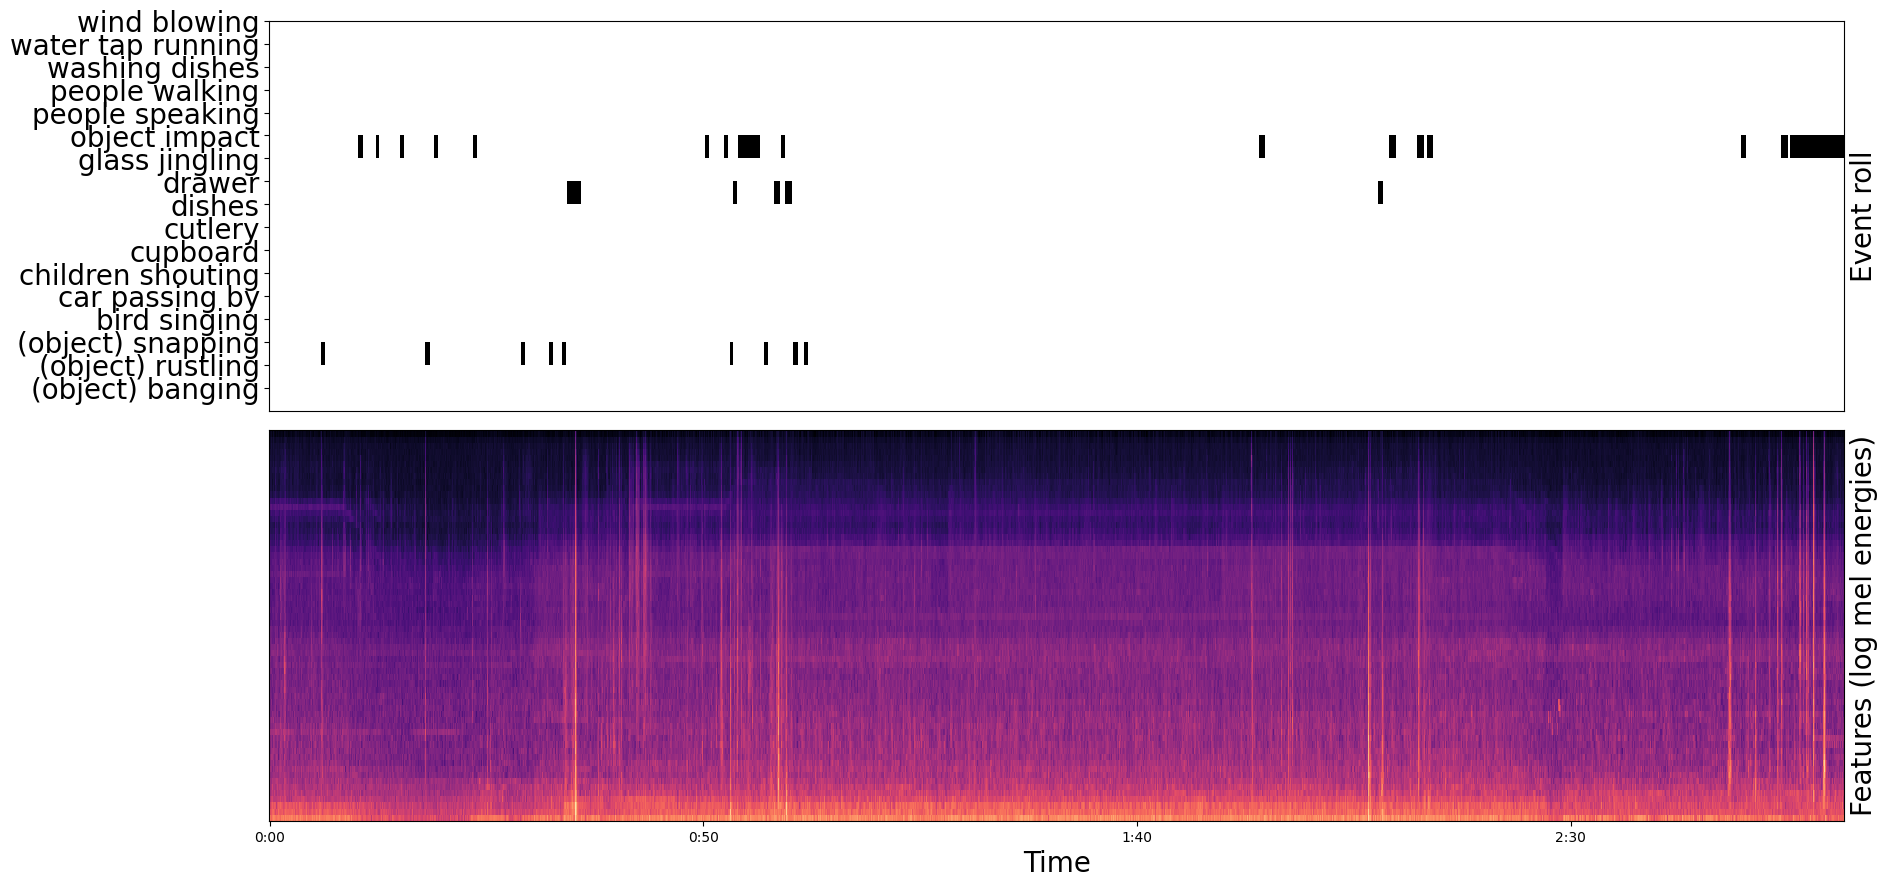

In [11]:
print('event_roll shape', '(classes, time)', event_roll.shape)

audio = AudioContainer().load(
    filename=db.meta.unique_files[0],
    mono=True
)
mel_data = mel_extractor.extract(y=audio)
feature_container = dcase_util.containers.FeatureContainer(
    data=mel_data, 
    time_resolution=mel_extractor.hop_length_seconds
)
event_roll.plot(
    data_container=feature_container, 
    figsize=(18,8), 
    data_panel_title='Features (log mel energies)', 
    binary_panel_title='Event roll',
    panel_title_position='right'
)

# Cross-validation set

Dataset is bundled with **4-fold** cross-validation set (train/test), **in this example we use only first fold**

**Validation set** is split from training set to have similar event distribution, however, recordings contain variable amount of events:
- Place recordings either into training or validation set 
- Measure distance of event counts to target split percentage (70/30)
- Select best match after multiple trials
- Split can be done with dataset handling class from `dcase_util` 

In [12]:
current_fold = 1
training_files, validation_files = db.validation_split(
    validation_amount=0.3, 
    fold=current_fold, 
    iterations=50,
    disable_progress_bar=False
)
train_meta = db.train(current_fold).filter(file_list=training_files)
validation_meta = db.train(current_fold).filter(file_list=validation_files)

Generate validation split candidates:   0%|          | 0/50 [00:00<?, ?it/s]

Generate validation split candidates:   0%|          | 0/50 [00:00<?, ?it/s]

#### Training/Validation/Test Statistics

In [13]:
print('Training files         :', len(training_files))
print('Validation files       :', len(validation_files))
print('Validation file amount :', '{0:2.2f}%'.format(
    len(validation_files) / float(len(validation_files) + len(training_files))* 100.0))

train_items = train_meta.stats()['events']['count']
train_items = numpy.append(train_items, numpy.sum(train_items))

validation_items = validation_meta.stats()['events']['count']
validation_items = numpy.append(validation_items, numpy.sum(validation_items))

test_items = db.eval(1).stats()['events']['count']
test_items = numpy.append(test_items, numpy.sum(test_items))

labels = db.event_labels() 
labels.append('Overall')

log.table(
    cell_data=[
        labels, 
        train_items,         
        validation_items,  
        validation_items / (train_items + validation_items) * 100.0,
        #test_items
    ],
    column_headers=['Event label', 'Train set (events)', 'Validation set (events)', 'Validation data amount (%)', 
                    #'Test set (events)',
                   ],
    column_types=['str25', 'int', 'int', 'float1', 'int', 'int', 'int', 'int', 'int'],
    column_separators=[0,2],
    row_separators=[6],
    scaling=90
)

Training files         : 10
Validation files       : 6
Validation file amount : 37.50%


Event label,Train set (events),Validation set (events),Validation data amount (%)
(object) banging,8,3,27.3
(object) rustling,5,32,86.5
(object) snapping,19,11,36.7
bird singing,86,23,21.1
car passing by,40,6,13.0
children shouting,21,2,8.7
cupboard,13,3,18.8
cutlery,49,3,5.8
dishes,50,9,15.3
drawer,15,7,31.8


## Features

# For each learning example, we need **feature matrix** and **target matrix** (event roll)

Data is split into fixed length **sequences** (10 seconds, non-overlapping)

1) **Feature** matrix:

In [14]:
# Extract features
features = mel_extractor.extract(
    AudioContainer().load(filename=train_meta.unique_files[0], mono=True)
)
# Split feature matrix into sequences
data_sequencer = dcase_util.data.Sequencer(
    sequence_length=sequence_length
) 
sequences = data_sequencer.sequence(features).data # (40, 500, 18)
# Reshape matrix to have sequences at first axis
X = numpy.moveaxis(sequences, 2, 0)
print('Data shape', '(sequence, frequency, time)', X.shape)
print('18 examples, each is 10s of audio in train_meta.unique_files[0] ~ 180s')

Data shape (sequence, frequency, time) (18, 64, 500)
18 examples, each is 10s of audio in train_meta.unique_files[0] ~ 180s


2) **Target** matrix (event roll):

In [15]:
# Get event list for the current item 
event_list = train_meta.filter(filename=train_meta.unique_files[0]) 

# Time resolution of feature extraction
feature_matrix_time_resolution = mel_extractor.hop_length_seconds
# Feature matrix length (seconds), needed to make event roll same size
feature_matrix_length = features.shape[1]*mel_extractor.hop_length_seconds

# Translate event list into event roll
event_roll = event_list.to_event_roll(
    label_list=db.event_labels(),                      # Event labels
    time_resolution=feature_matrix_time_resolution,
    length_seconds=feature_matrix_length
)

# Reshape matrix to have sequences at first axis
Y = numpy.moveaxis(data_sequencer.sequence(event_roll).data, 2, 0)
print('Data shape', '(sequence, event classes, time)', Y.shape)

Data shape (sequence, event classes, time) (18, 17, 500)


#### Collect training data

In [16]:
X_train = []
Y_train = []
for audio_filename in train_meta.unique_files:
    print('Load', db.absolute_to_relative_path(audio_filename))
    
    # Extract features, load them from file if they exists, if not extract and save
    features = get_feature_matrix(audio_filename, feature_storage_path)
    feature_sequence = data_sequencer.sequence(features)
    # Extract features, store only in memory
    #features = mel_extractor.extract(
    #    dcase_util.containers.AudioContainer().load(filename=item.filename,mono=True)
    #)

    # Targets
    event_list = train_meta.filter(filename=audio_filename)
    event_roll = event_list.to_event_roll(
        label_list=db.event_labels(),                                       # Event labels
        time_resolution=mel_extractor.hop_length_seconds,                   # Time resolution of feature matrix
        length_seconds=features.shape[1]*mel_extractor.hop_length_seconds   # Length of original audio signal
    )
    target_matrix = data_sequencer.sequence(event_roll)
    
    X_train.append(numpy.moveaxis(feature_sequence.data,2,0)) 
    Y_train.append(numpy.moveaxis(target_matrix.data,2,0))
    
X_train = numpy.vstack(X_train)
Y_train = numpy.vstack(Y_train)
print('----------------------')
print('X_train shape', X_train.shape)
print('Y_train shape', Y_train.shape)

Load audio/home/a030.wav
Load audio/home/a034.wav
Load audio/home/a036.wav
Load audio/home/b030.wav
Load audio/residential_area/a002.wav
Load audio/residential_area/a011.wav
Load audio/residential_area/a012.wav
Load audio/residential_area/b002.wav
Load audio/residential_area/b007.wav
Load audio/residential_area/b009.wav
----------------------
X_train shape (207, 64, 500)
Y_train shape (207, 17, 500)


In [17]:
X_validation = []
Y_validation = []
validation_data = {}
for audio_filename in validation_meta.unique_files:
    print('Load', db.absolute_to_relative_path(audio_filename))
    
    # Extract features, load them from file if they exists, if not extract and save
    features = get_feature_matrix(audio_filename, feature_storage_path)
    feature_sequence = data_sequencer.sequence(features)
    # Extract features, store only in memory
    #features = mel_extractor.extract(
    #    dcase_util.containers.AudioContainer().load(filename=item.filename,mono=True)
    #)

    # Targets
    event_list = validation_meta.filter(filename=audio_filename)
    event_roll = event_list.to_event_roll(
        label_list=db.event_labels(),                                       # Event labels
        time_resolution=mel_extractor.hop_length_seconds,                   # Time resolution of feature matrix
        length_seconds=features.shape[1]*mel_extractor.hop_length_seconds   # Length of original audio signal
    )
    target_matrix = data_sequencer.sequence(event_roll)
    
    X_validation.append(numpy.moveaxis(feature_sequence.data,2,0)) 
    Y_validation.append(numpy.moveaxis(target_matrix.data,2,0))
    
    validation_data[audio_filename] = {
        'features': features,
        'meta': event_list
    }
        
X_validation = numpy.vstack(X_validation)
Y_validation = numpy.vstack(Y_validation)
print('----------------------')
print('X_validation shape', X_validation.shape)
print('Y_validation shape', Y_validation.shape)

Load audio/home/a031.wav
Load audio/home/b029.wav
Load audio/home/b033.wav
Load audio/residential_area/a003.wav
Load audio/residential_area/a013.wav
Load audio/residential_area/b004.wav
----------------------
X_validation shape (127, 64, 500)
Y_validation shape (127, 17, 500)


In [18]:
print('X_train shape', '(sequence, frequency    , time)', X_train.shape)
print('Y_train shape', '(sequence, event classes, time)', Y_train.shape)

X_train shape (sequence, frequency    , time) (207, 64, 500)
Y_train shape (sequence, event classes, time) (207, 17, 500)


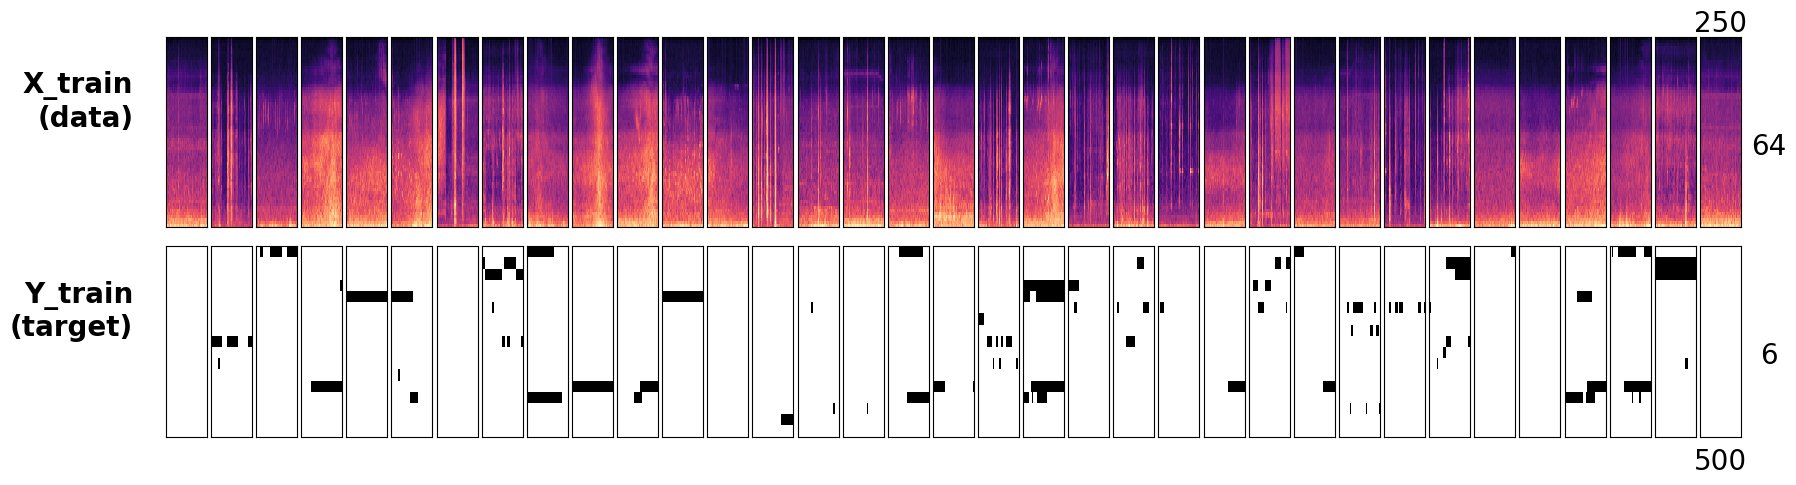

In [19]:
example_ids = numpy.random.choice(range(X_train.shape[0]), 35, replace=False)

fig, axes = plt.subplots(2, len(example_ids), figsize=(18, 4))
fig.subplots_adjust(top=1.0, bottom=0.0, right=1.0, hspace=0.1, wspace=0.1)

for i, item_id in enumerate(example_ids):
    current_x = X_train[item_id,:,:]
    current_y = Y_train[item_id,:,:]
        
    plt.sca(axes[0, i])
    dcase_util.containers.FeatureContainer(current_x).plot(plot=False)
    
    plt.sca(axes[1, i])
    dcase_util.containers.BinaryMatrix2DContainer(current_y).plot(plot=False)

axes[0, -1].yaxis.set_label_position("right")
axes[0, -1].xaxis.set_label_position("top")
axes[0, -1].set_ylabel('64', rotation=0, fontsize=20, labelpad=20)
axes[0, -1].set_xlabel('250',fontsize=20)

axes[1, -1].yaxis.set_label_position("right")
axes[1, -1].xaxis.set_label_position("bottom")
axes[1, -1].set_ylabel('6', rotation=0, fontsize=20, labelpad=20)
axes[1, -1].set_xlabel('500',fontsize=20)

axes[0, 0].set_ylabel('X_train\n(data)', rotation=0, fontsize=20, labelpad=20, fontweight='bold', ha='right')
axes[1, 0].yaxis.set_label_position("left")
axes[1, 0].set_ylabel('Y_train\n(target)', rotation=0, fontsize=20, labelpad=20, fontweight='bold', ha='right')    

axes[0, i].yaxis.label.set_visible(True)
axes[1, i].yaxis.label.set_visible(True)

## Model

In [22]:
feature_vector_length = mel_extractor.n_mels   # Number of mel bands
print(feature_vector_length)

64


In [25]:
input_layer = Input(
    shape=(feature_vector_length, sequence_length), 
    name='Input'
)
x = Reshape(
    target_shape=(feature_vector_length, sequence_length, 1), 
    name='Input_Reshape'
)(input_layer)

print('Output shape','(sequence, frequency, time, channel)', x.shape)

Output shape (sequence, frequency, time, channel) (None, 64, 500, 1)


**Two convolutional groups** are used to capture small shifts in time and frequency. 

Similar groups as in sound classification example, except max **pooling done only along frequency** axis as time axis is retained for the detection.

- **Convolution** to extract high-level features (kernel 3x3 and 64 filters)
- **Batch normalization** to enable higher learning rates
- **Activation** (ReLu)
- **Pooling** along frequency axis to extract dominant features
- **Dropout** to avoid overfitting

#### Conv 1

In [26]:
print('Input shape','(sequence, frequency, time, channel)', x.shape)

Input shape (sequence, frequency, time, channel) (None, 64, 500, 1)


In [27]:
# Convolution
x = Conv2D(filters=conv_filters, kernel_size=(3, 3), activation='linear',
           padding='same', data_format='channels_last', name='Conv1')(x)
# Batch normalization
x = BatchNormalization(axis=-1, name='Conv1_BatchNorm')(x)
# Activation
x = Activation(activation='relu', name='Conv1_Activation')(x)
# Max pooling along frequency axis
x = MaxPooling2D(pool_size=(8,1), name='Conv1_Pooling')(x)
# Drop out
x = Dropout(rate=dropout, name='Conv1_DropOut')(x)


In [28]:
print('Output shape', '(sequence, frequency, time, feature)', x.shape)

Output shape (sequence, frequency, time, feature) (None, 8, 500, 128)


#### Conv 2

In [251]:
print('Input shape','(sequence, frequency, time, channel)', x.shape)

Input shape (sequence, frequency, time, channel) (None, 8, 500, 128)


In [29]:
# Convolution
x = Conv2D(filters=conv_filters, kernel_size=(3, 3), activation='linear',
           padding='same', data_format='channels_last', name='Conv2')(x)
# Batch normalization
x = BatchNormalization(axis=-1, name='Conv2_BatchNorm')(x)
# Activation
x = Activation(activation='relu', name='Conv2_Activation')(x)
# Max pooling along frequency axis
x = MaxPooling2D(pool_size=(4,1), name='Conv2_Pooling')(x)
# Drop out
x = Dropout(rate=dropout, name='Conv2_DropOut')(x)

In [253]:
print('Output shape', '(sequence, frequency, time, feature)', x.shape)

Output shape (sequence, frequency, time, feature) (None, 2, 500, 128)


#### Conv 3

In [254]:
print('Input shape','(sequence, frequency, time, channel)', x.shape)

Input shape (sequence, frequency, time, channel) (None, 2, 500, 128)


In [30]:
# Convolution
x = Conv2D(filters=conv_filters, kernel_size=(3, 3), activation='linear',
           padding='same', data_format='channels_last', name='Conv3')(x)
# Batch normalization
x = BatchNormalization(axis=-1, name='Conv3_BatchNorm')(x)
# Activation
x = Activation(activation='relu', name='Conv3_Activation')(x)
# Max pooling along frequency axis
x = MaxPooling2D(pool_size=(2,1), name='Conv3_Pooling')(x)
# Drop out
x = Dropout(rate=dropout, name='Conv3_DropOut')(x)

In [31]:
print('Output shape', '(sequence, frequency, time, feature)', x.shape)

Output shape (sequence, frequency, time, feature) (None, 1, 500, 128)


To **connect** convolutional layers and recurrent layers, output of the last convolutional group has to be  **Reordered** and **Reshaped**:

In [32]:
x = Permute(
    dims=(1, 3, 2), 
    name='Permute'
)(x)

x = Reshape(
    target_shape=(sequence_length, -1), 
    name='Reshape'
)(x)

print('Output shape', '(sequence, time, feature)', x.shape)

Output shape (sequence, time, feature) (None, 500, 128)


One **bidirectional** **recurrent** layer (Gated Recurrent Unit) is used to integrate information from large time window:

In [33]:
x = Bidirectional(
    GRU(
        units=gru_units, activation='tanh', 
        dropout=dropout, recurrent_dropout=dropout, 
        return_sequences=True
    ), merge_mode='mul', name='GRU_1'
)(x)

**Recognition** is done with one **fully-connected** layers using information extracted by the previous layers. 

Layers are wrapped with `TimeDistributed` class to apply layers independently to each time step.

**Output layer** (last fully-connected layer) is with sigmoid activation. (***needs GAP according to DESED paper***)

In [34]:
x = TimeDistributed(
    Dense(units=gru_units), name='FC'
)(x)
x = Dropout(rate=0.2, name='FC_DropOut')(x)
x = TimeDistributed(
    Dense(units=len(db.event_labels())), name='Output'
)(x)
output_layer = Activation('sigmoid', name='Output_Activation')(x)

In [35]:
print('Output shape', '(sequence, time, classes)', output_layer.shape)

Output shape (sequence, time, classes) (None, 500, 17)


### Compile model

In [36]:
model = Model(inputs=input_layer, outputs=output_layer)

In [39]:
print(model.summary())
# **** You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work
import tensorflow as tf
tf.keras.utils.plot_model(
    model,
    to_file='model.png',
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=False,
#     show_trainable=False
)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 64, 500)]         0         
                                                                 
 Input_Reshape (Reshape)     (None, 64, 500, 1)        0         
                                                                 
 Conv1 (Conv2D)              (None, 64, 500, 128)      1280      
                                                                 
 Conv1_BatchNorm (BatchNorma  (None, 64, 500, 128)     512       
 lization)                                                       
                                                                 
 Conv1_Activation (Activatio  (None, 64, 500, 128)     0         
 n)                                                              
                                                                 
 Conv1_Pooling (MaxPooling2D  (None, 8, 500, 128)      0     